In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import datetime

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
#import pyLDAvis.gensim #LDA visualization library

import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain


#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'spline' from 'scipy.interpolate' (C:\Users\etien\anaconda3\lib\site-packages\scipy\interpolate\__init__.py)

In [2]:
data_folder = './MovieSummaries/'

summaries = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])
char_meta = pd.read_csv(data_folder+'character.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "release_date", "character_name", "birth", "gender", "height", "ethnicity", "actor_name", "actor_age", "character_actor_map", "character_id", "actor_id"])

In [3]:
# mergin databases
summaries = summaries.merge(movie_meta, on="wiki_id", how = 'right')
summaries["languages"] = summaries.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
summaries["coutries"] = summaries.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
summaries["genres"] = summaries.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [4]:
summaries.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
0,975900,"Set in the second half of the 22nd century, th...",/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,NaN,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,NaN,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,A series of murders of rich young women throug...,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,"Eva, an upper class housewife, becomes frustra...",/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [5]:
len(summaries)

81741

In [6]:
# df is used for average sentiment analysis over movies
df = summaries.copy()

In [7]:
df.loc[df['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(df['release_date'])
df['release_date'] = dates

In [8]:
df = df.sort_values(by=['release_date'])

In [9]:
df = df.dropna(subset=['summary'])

In [10]:
df.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
25563,73372,The scene is all filmed from a stationary came...,/m/0jq3g,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67253,10109752,After finding out that her father is suffering...,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
81230,10104497,James J. Corbett and Peter Courtney both take ...,/m/02q1zd3,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67567,10330688,The film consists of a series of animations on...,/m/02q8pr6,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Short Film, Silent film, Animation, Comedy, I..."
73179,10483292,Two men stand working as blacksmiths. The one ...,/m/02qfh7r,Les Forgerons,1895-01-01,NaN,0.816667,[Silent film],[France],"[Short Film, Silent film, Indie, Black-and-whi..."


In [11]:
len(df)

42204

Here we have that df contains all the movies with their informations, ordered by release date with a existing summary. We will use this to derive all our other dataframes (per countries, per date). We have 42204 movies compared to 81741 before.

In [12]:
analyzer = SentimentIntensityAnalyzer()

In [13]:
def get_country_movies(df, country):
    return df[df.coutries.apply(lambda x : country in x)]

In [14]:
def create_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year < end) & (df.release_date.dt.year > begin)]

In [15]:
def plot_sentiment_country_span(span, attribute, year:bool):
    fig, axs = plt.subplots(figsize=(25, 5))
    if year:
        sentiments = span.groupby(span.release_date.dt.year)[attribute].mean()
    else:
        sentiments = span.groupby(span.release_date)[attribute].mean()
    sentiments.plot(kind='bar', rot=90, ax=axs)

In [16]:
def sentiment_df(df):
    
    df_copy = df.copy()
    
    # calculate the sentiment over the summaries
    df_copy['sentiment'] = df_copy['summary'].apply(lambda x: analyzer.polarity_scores(x))

    # isolate the most interesting values
    df_copy['positive'] = df_copy['sentiment'].apply(lambda x: x['pos'])
    df_copy['neutral'] = df_copy['sentiment'].apply(lambda x: x['neu'])
    df_copy['negative'] = df_copy['sentiment'].apply(lambda x: x['neg'])
    df_copy['compound'] = df_copy['sentiment'].apply(lambda x: x['compound'])
    
    return df_copy

Firstly we'll just look at movies made around the WW2, that is from 1930 to 1955.

In [17]:
begin = 1930
end = 1955

In [18]:
df_ww2 = create_history_span(df, begin, end)
print("There is", len(df_ww2), "movies made worldwide bewteen", begin, "and", end)

There is 5341 movies made worldwide bewteen 1930 and 1955


We will first run a sentiment analysis over all **german** movie during this period **(1930 to 1955)**.

In [19]:
# get all the german movies
df_ww2_germany = get_country_movies(df_ww2, 'Germany')

# calculate sentiment and add it nicely to the df
df_ww2_germany = sentiment_df(df_ww2_germany)

In [20]:
print("There is", len(df_ww2_germany), "movies made in Germany bewteen", begin, "and", end)

There is 69 movies made in Germany bewteen 1930 and 1955


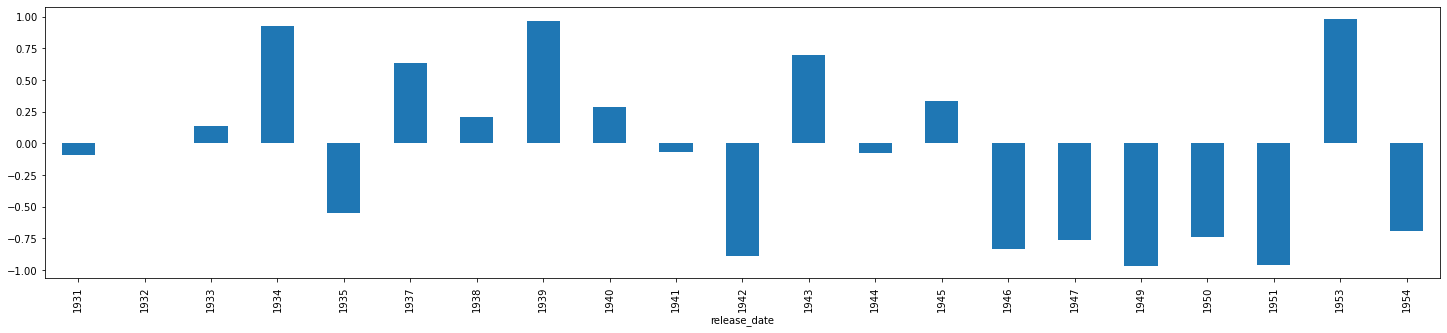

In [21]:
plot_sentiment_country_span(df_ww2_germany, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1946-1951) overall sentiment is negative.

---

We then run a sentiment analysis over all **french** movie during this period **(1930 to 1955)**.

In [22]:
# get all the french movies
df_ww2_french = get_country_movies(df_ww2, 'France')

# calculate sentiment and add it nicely to the df
df_ww2_french = sentiment_df(df_ww2_french)

In [23]:
print("There is", len(df_ww2_french), "movies made in France bewteen", begin, "and", end)

There is 100 movies made in France bewteen 1930 and 1955


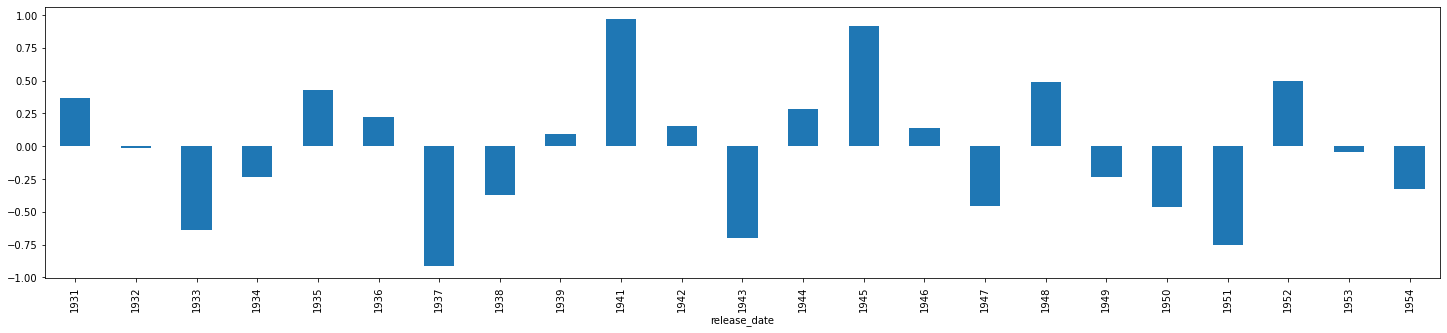

In [24]:
plot_sentiment_country_span(df_ww2_french, 'compound', year=True)

We can't see any form of pattern here ?... Except the 1945 year that is very positive (victory for France)

---

We then run a sentiment analysis over all **italy** movie during this period **(1930 to 1955)**.

In [25]:
# get all the french movies
df_ww2_italy = get_country_movies(df_ww2, 'Italy')

# calculate sentiment and add it nicely to the df
df_ww2_italy = sentiment_df(df_ww2_italy)

In [26]:
print("There is", len(df_ww2_italy), "movies made in Italy bewteen", begin, "and", end)

There is 73 movies made in Italy bewteen 1930 and 1955


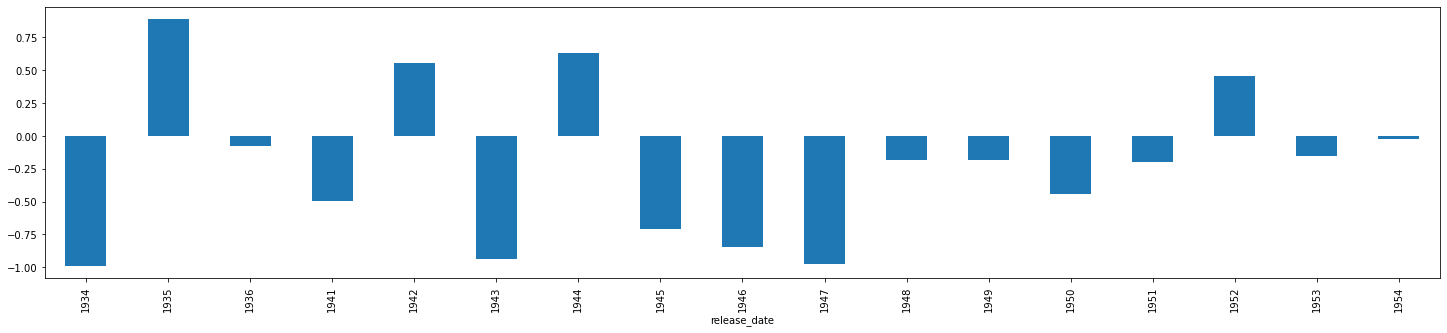

In [27]:
plot_sentiment_country_span(df_ww2_italy, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1945-1949) overall sentiment is negative.

---

We then run a sentiment analysis over all **united kingdom** movie during this period **(1930 to 1955)**.

In [28]:
# get all the UK movies
df_ww2_UK = get_country_movies(df_ww2, 'United Kingdom')

# calculate sentiment and add it nicely to the df
df_ww2_UK = sentiment_df(df_ww2_UK)

In [29]:
print("There is", len(df_ww2_UK), "movies made in UK bewteen", begin, "and", end)

There is 593 movies made in UK bewteen 1930 and 1955


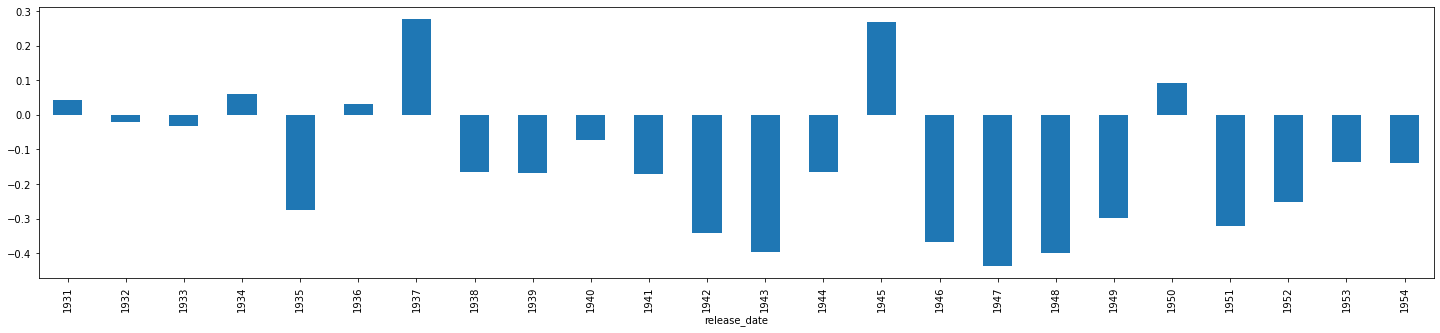

In [30]:
plot_sentiment_country_span(df_ww2_UK, 'compound', year=True)

Seeing the compound value of all the movies at this period we can see that the war (1939-1945) overall sentiment is negative, execpt the last year (vicory for UK) where it is positive. 
Also the post war period is tainted with negativity  (1946 - 1951)

---

We then run a sentiment analysis over all **soviet union** movie during this period **(1930 to 1955)**.

In [31]:
# get all the Russian movies
df_ww2_SovietUnion = get_country_movies(df_ww2, 'Soviet Union')

# calculate sentiment and add it nicely to the df
df_ww2_SovietUnion = sentiment_df(df_ww2_SovietUnion)

In [32]:
print("There is", len(df_ww2_SovietUnion), "movies made in Soviet Union bewteen", begin, "and", end)

There is 24 movies made in Soviet Union bewteen 1930 and 1955


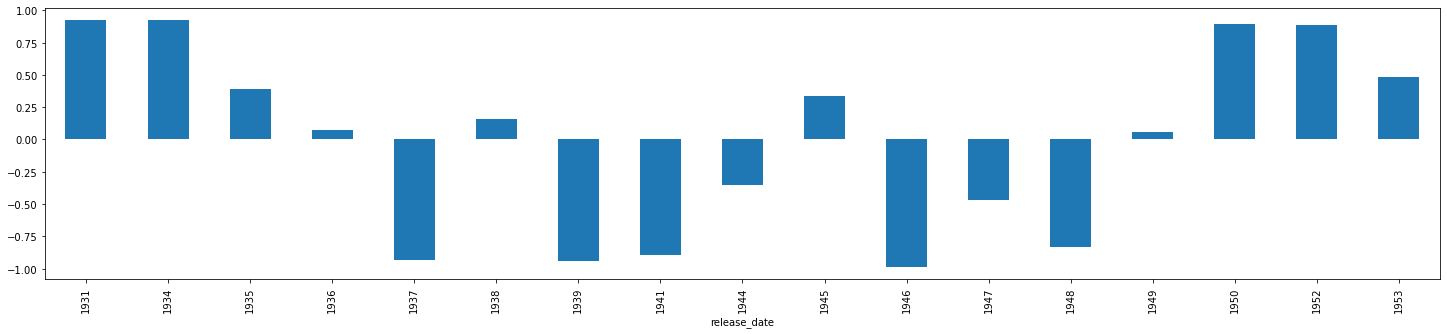

In [33]:
plot_sentiment_country_span(df_ww2_SovietUnion, 'compound', year=True)

We then run a sentiment analysis over all **USA** movie during this period **(1930 to 1955)**.

In [34]:
# get all the USA movies
df_ww2_USA = get_country_movies(df_ww2, 'United States of America')

# calculate sentiment and add it nicely to the df
df_ww2_USA = sentiment_df(df_ww2_USA)

In [35]:
print("There is", len(df_ww2_USA), "movies made in USA bewteen", begin, "and", end)

There is 3863 movies made in USA bewteen 1930 and 1955


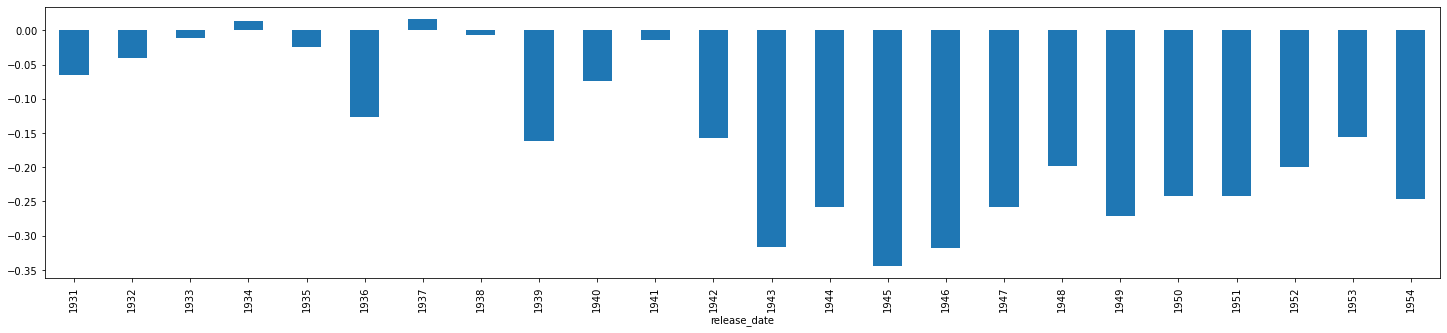

In [36]:
plot_sentiment_country_span(df_ww2_USA, 'compound', year=True)

Seeing the compound value of all the movies at this period we can see that the war and prewar (1941-1951) overall sentiment is very negative. There is a clear mark between before the involvement of USA in the war and after.

---

We then run a sentiment analysis over all **Japan** movie during this period **(1930 to 1955)**.

In [37]:
# get all the Japan movies
df_ww2_japan = get_country_movies(df_ww2, 'Japan')

# calculate sentiment and add it nicely to the df
df_ww2_japan = sentiment_df(df_ww2_japan)

In [38]:
print("There is", len(df_ww2_japan), "movies made in Japan bewteen", begin, "and", end)

There is 44 movies made in Japan bewteen 1930 and 1955


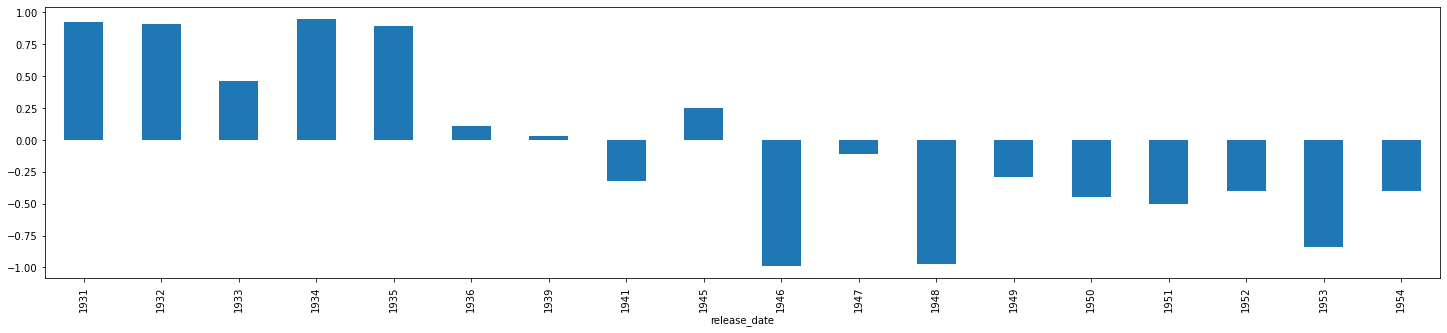

In [39]:
plot_sentiment_country_span(df_ww2_japan, 'compound', year=True)

Pre war (before 1939)  is pretty positive. The rest of the period is moslty negative.

---

### We will now do LDA.

In [40]:
lemma = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
names_set = {'lucas', 'pierre', 'baptiste', 'garance', 'marius', 'jean', 'roxane', 'jeanne', 'george', 'émile', 'louis', 'louise', 'robert', 
             'mario', 'françois', 'fanny', 'liliom', 'michel', 'frédérick', 'christina', 'christian', 'christine', 'andré', 'george', 
             'edmund', 'julie', 'marie', 'jo', 'anne', 'genevieve'}


# remove stopwords and punctuation
def clean_text(text):
    no_stopwords = ' '.join([word for word in text.lower().split() if word not in stopwords_set])
    no_punctuation = ''.join(ch for ch in no_stopwords if ch not in punctuation_set)
    no_names = ' '.join([word for word in no_punctuation.split() if word not in names_set])
    return no_names

# lemmatize the text
def lemmatize(text):
    lemmatized = ' '.join([lemma.lemmatize(word) for word in text.split()])
    return lemmatized.split()

# compute the LDA for the given dataframe
def LDA(dataframe, num_topics=5):
    
    # remove stopwords and punctuation in the summaries
    dataframe['clean_summary'] = dataframe['summary'].apply(clean_text)
    
    # lemmatize the summaries
    dataframe['clean_summary'] = dataframe['clean_summary'].apply(lemmatize)
    
    # create dictionary (all unique words in all the summaries)
    dictionary = corpora.Dictionary(dataframe['clean_summary'])
    
    # create the document term matrix (frequencies and number of words : bag of words)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataframe['clean_summary']]

    # init the LDA model
    lda = gensim.models.ldamodel.LdaModel
    
    # compute the LDA
    ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)
    
    # print the topics found
    print("--- Here are all the topics found : ---")
    topics = ldamodel.print_topics()
    for i in range(len(topics)):
        print(topics[i])
        print("---")
        
    lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=True, mds='mmds')
    
    return lda_display, doc_term_matrix, ldamodel

In [41]:
display_ger, doc_term_matrix_ger, ldamodel_ger = LDA(df_ww2_germany, num_topics=3)
pyLDAvis.display(display_ger)

--- Here are all the topics found : ---
(0, '0.006*"baron" + 0.006*"gray" + 0.005*"find" + 0.004*"young" + 0.004*"love" + 0.004*"village" + 0.004*"man" + 0.004*"dr" + 0.003*"one" + 0.003*"woman"')
---
(1, '0.008*"film" + 0.006*"father" + 0.005*"nazi" + 0.005*"hitler" + 0.005*"friedemann" + 0.004*"german" + 0.004*"son" + 0.003*"day" + 0.003*"family" + 0.003*"party"')
---
(2, '0.005*"snowman" + 0.005*"war" + 0.004*"french" + 0.004*"german" + 0.004*"film" + 0.004*"krüger" + 0.003*"british" + 0.003*"find" + 0.003*"two" + 0.003*"leader"')
---


In [45]:
# p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_html(display_ger, 'lda.html')

In [42]:
# assigns the topics to the summaries
lda_corpus_ger = ldamodel_ger[doc_term_matrix_ger]

In [43]:
threshold = 1/3

cluster1 = [j for i,j in zip(lda_corpus_ger, df_ww2_germany['movie_name']) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus_ger, df_ww2_germany['movie_name']) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus_ger, df_ww2_germany['movie_name']) if i[2][1] > threshold]

In [44]:
df_ww2_germany['movie_name'].apply(lambda x: x if x in cluster1 else np.nan).dropna()

11854                                     M
37861                Der Raub der Mona Lisa
44975                      Happy Ever After
8456           Das Testament des Dr. Mabuse
73773                        The Blue Light
20435                       Venetian Nights
69650                                Vampyr
907                         The Living Dead
58708                   Master of the World
29362                           La Habanera
32913                   Festliches Nürnberg
20230                       Der Postmeister
37997                         Wunschkonzert
73403                       The Golden City
64800    The Adventures of Baron Munchausen
15526                               Titanic
67819                              Immensee
11306                  Die Feuerzangenbowle
34625                  Große Freiheit Nr. 7
68856                    Murderers Among Us
50665                   Council of the Gods
42329                              La Paura
Name: movie_name, dtype: object